# 1. Csv -> Txt

In [2]:
import pandas as pd
import re
from pathlib import Path

CSV_PATH = r"D:\AMS_Year5\Semester_1\TP_IWR\Khmer-Text-Prediction\dataset\csv\khPOS.csv"
OUT_TXT = r"D:\AMS_Year5\Semester_1\TP_IWR\Khmer-Text-Prediction\dataset\cleaned_txt\full.txt"

def parse_tokens(cell) -> list[str]:
    """
    Parse tokens from weird CSV formats like:
      "['ក្រៅ_ពី' 'នោះ' ... '។']"
      "['លោក~ជំទាវ' 'ណោន' 'សារម្យ']"
      "['a', 'b', 'c']"   (if it ever appears)
    Return a list of token strings.
    """
    if pd.isna(cell):
        return []

    s = str(cell).strip()

    # Remove outer brackets if present
    if s.startswith("[") and s.endswith("]"):
        s = s[1:-1].strip()

    # Case 1: tokens are separated by spaces and wrapped in single quotes:  'tok1' 'tok2'
    tokens = re.findall(r"'([^']*)'", s)
    if tokens:
        return tokens

    # Case 2: fallback: maybe comma-separated without quotes (rare) -> split by comma
    # (You can remove this fallback if you’re sure you always have quotes)
    parts = [p.strip() for p in s.split(",") if p.strip()]
    return parts

def tokens_to_sentence(tokens: list[str]) -> str:
    # Join with NO spaces to match your example
    return "".join(tokens).strip()

def main():
    df = pd.read_csv(CSV_PATH)

    sentences = []
    for cell in df["tokens"]:
        toks = parse_tokens(cell)
        sent = tokens_to_sentence(toks)
        sentences.append(sent)

    # write one sentence per line (UTF-8)
    Path(OUT_TXT).write_text("\n".join(sentences) + "\n", encoding="utf-8")

    print(f"Saved {len(sentences)} lines to {OUT_TXT}")

if __name__ == "__main__":
    main()


Saved 12000 lines to D:\AMS_Year5\Semester_1\TP_IWR\Khmer-Text-Prediction\dataset\cleaned_txt\full.txt


# 2. Json -> txt

In [4]:
import json

JSON_PATH = r"D:\AMS_Year5\Semester_1\TP_IWR\Khmer-Text-Prediction\dataset\json\train.json"
OUT_TXT = r"D:\AMS_Year5\Semester_1\TP_IWR\Khmer-Text-Prediction\dataset\cleaned_txt\full.txt"

with open(JSON_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)

count = 0
with open(OUT_TXT, "a", encoding="utf-8") as out:
    for item in data:
        sentence = item.get("text", "").strip()
        if sentence:
            out.write(sentence + "\n")
            count += 1

print(f"Appended {count} sentences to full.txt")


Appended 1050 sentences to full.txt


In [5]:
import json

JSON_PATH = r"D:\AMS_Year5\Semester_1\TP_IWR\Khmer-Text-Prediction\dataset\json\train.json"

with open(JSON_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)

if isinstance(data, list):
    print(f"JSON contains {len(data)} objects (list of dicts).")

elif isinstance(data, dict):
    print("JSON contains 1 object (single dict).")
    print(f"Keys: {list(data.keys())}")

else:
    print(f"JSON contains unsupported type: {type(data)}")


JSON contains 1050 objects (list of dicts).


# 3. Jsonl -> txt

In [9]:
import json

JSONL_PATH = r"D:\AMS_Year5\Semester_1\TP_IWR\Khmer-Text-Prediction\dataset\jsonl\val.jsonl"
OUT_TXT = r"D:\AMS_Year5\Semester_1\TP_IWR\Khmer-Text-Prediction\dataset\cleaned_txt\full.txt"

count = 0
skipped = 0

with open(JSONL_PATH, "r", encoding="utf-8") as infile, \
     open(OUT_TXT, "a", encoding="utf-8") as outfile:

    for line in infile:
        line = line.strip()
        if not line:
            continue

        obj = json.loads(line)

        question = (obj.get("question") or "").strip()
        answer   = (obj.get("answer")   or "").strip()

        if not question and not answer:
            skipped += 1
            continue

        if question:
            outfile.write(question + "\n")
        if answer:
            outfile.write(answer + "\n")

        count += 1

print(f"Processed {count} JSONL entries")
print(f"Skipped {skipped} empty entries")


Processed 484 JSONL entries
Skipped 0 empty entries


# 4. Clean the txt

In [6]:
import re
import unicodedata

class TextCleaning:
    def __init__(self, khmer_ratio_threshold=0.6):
        self.khmer_ratio_threshold = khmer_ratio_threshold

        # Patterns
        self.khmer_pattern = re.compile(r"[\u1780-\u17FF]")
        self.invisible_pattern = re.compile(r"[\u200B-\u200D\uFEFF]")
        self.html_pattern = re.compile(r"<[^>]+>")

    def clean_line(self, text: str) -> str:
        """
        Clean ONE line while preserving line index.
        Never removes or shifts lines.
        """

        # 1. Unicode normalization NFC
        text = unicodedata.normalize("NFC", text)

        # 2. Remove HTML tags
        text = self.html_pattern.sub("", text)

        # 3. Remove zero-width / invisible characters
        text = self.invisible_pattern.sub("", text)

        # 4. Remove noisy separators (_ and ~)
        text = re.sub(r"[_~]+", "", text)

        # 5. Normalize whitespace
        text = re.sub(r"\s+", " ", text).strip()

        # 6. Optional: non-Khmer dominant → keep line but empty
        if text and not self._is_khmer_dominant(text):
            return ""

        return text

    def _is_khmer_dominant(self, text: str) -> bool:
        khmer_chars = len(self.khmer_pattern.findall(text))
        total_chars = len(re.sub(r"\s", "", text))

        if total_chars == 0:
            return False

        return (khmer_chars / total_chars) >= self.khmer_ratio_threshold


Total lines: 305653
Min chars: 10
Max chars: 300
Average chars: 90.44955227005788


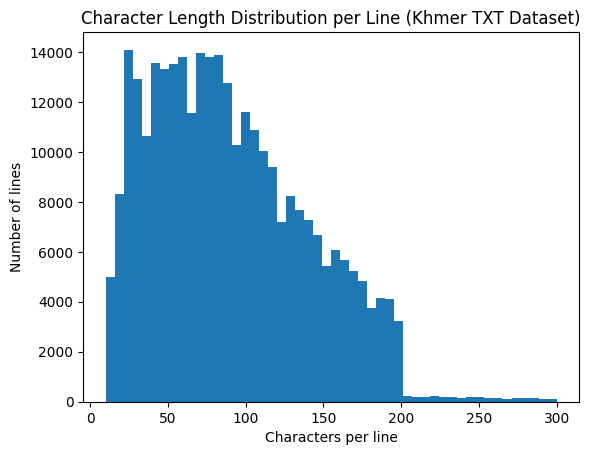

In [10]:
import matplotlib.pyplot as plt

# ===== CONFIG =====
input_file = r"D:\AMS_Year5\Semester_1\TP_IWR\Khmer-Text-Prediction\dataset\cleaned_txt\cleaned-general-text.txt"   # path to your txt file
MIN_CHARS = 0             # change if you want to ignore very short lines

# ===== READ FILE & COUNT CHARS =====
char_lengths = []

with open(input_file, "r", encoding="utf-8") as f:
    for line in f:
        text = line.strip()
        if len(text) >= MIN_CHARS:
            char_lengths.append(len(text))

# ===== BASIC STATS =====
print("Total lines:", len(char_lengths))
print("Min chars:", min(char_lengths))
print("Max chars:", max(char_lengths))
print("Average chars:", sum(char_lengths) / len(char_lengths))

# ===== PLOT =====
plt.figure()
plt.hist(char_lengths, bins=50)
plt.xlabel("Characters per line")
plt.ylabel("Number of lines")
plt.title("Character Length Distribution per Line (Khmer TXT Dataset)")
plt.show()


In [11]:
import sentencepiece as spm
import numpy as np
import matplotlib.pyplot as plt


In [14]:
# Load SentencePiece model
sp = spm.SentencePieceProcessor()
sp.load(r"D:\AMS_Year5\Semester_1\TP_IWR\Khmer-Text-Prediction\tokenizer\tokenizer.model")   # <-- change to your tokenizer path


True

In [15]:
txt_path = r"D:\AMS_Year5\Semester_1\TP_IWR\Khmer-Text-Prediction\dataset\cleaned_txt\cleaned-general-text.txt"  # <-- your dataset

token_lengths = []

with open(txt_path, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        
        tokens = sp.encode(line, out_type=str)
        token_lengths.append(len(tokens))


In [16]:
lengths = np.array(token_lengths)

print("Total sentences:", len(lengths))
print("Min tokens:", lengths.min())
print("Max tokens:", lengths.max())
print("Mean tokens:", round(lengths.mean(), 2))
print("Median tokens:", np.median(lengths))

print("\nPercentiles:")
print("90% <=", np.percentile(lengths, 90))
print("95% <=", np.percentile(lengths, 95))
print("99% <=", np.percentile(lengths, 99))


Total sentences: 305653
Min tokens: 2
Max tokens: 162
Mean tokens: 23.49
Median tokens: 21.0

Percentiles:
90% <= 41.0
95% <= 48.0
99% <= 64.0
